In [2]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
from sklearn.decomposition import PCA, FastICA
import cell2sentence as cs
from cell2sentence import tasks, CSData, CSModel
from cell2sentence.prompt_formatter import PromptFormatter
import ot
import cinemaot as co

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

In [3]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_preprocessed_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/mouse_pancreas_preprocessed_homolog_intersected_adata.h5ad")

In [4]:
human_restricted

AnnData object with n_obs × n_vars = 1937 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [5]:
human_restricted.X.data[:10]  # Already preprocessed, no need to filter/normalize

array([0.6448834 , 0.8580882 , 0.20411664, 0.20411664, 0.37354946,
       0.20411664, 0.20411664, 0.20411664, 0.20411664, 0.20411664],
      dtype=float32)

In [6]:
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [7]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0


In [8]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

In [9]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,organism,cell_type
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0,Homo sapiens,acinar
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0,Homo sapiens,acinar
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0,Homo sapiens,acinar
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0,Homo sapiens,acinar
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0,Homo sapiens,acinar


Data is already processed, no need to filter or normalize

Using Preprocessed data to embed cells

In [10]:
c2s_save_dir = "/home/dor3/scratch/C2S_Files/c2s_api_testing"  # C2S dataset will be saved into this directory
human_c2s_save_name = "human_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk
mouse_c2s_save_name = "mouse_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk

In [11]:
# arrow_dir='./data/'
# # ensure the directory for Arrow datasets exists
# os.makedirs(arrow_dir, exist_ok=True)

# # paths to Arrow datasets
# arrow_path_human = os.path.join(arrow_dir, 'human_arrow')
# arrow_path_mouse = os.path.join(arrow_dir, 'mouse_arrow')

# convert AnnData to Arrow format and save
'''# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)'''
human_arrow_ds, human_vocab = CSData.adata_to_arrow(
    adata=human_restricted, 
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

mouse_arrow_ds, mouse_vocab = CSData.adata_to_arrow(
    adata=mouse_restricted,
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

WARN: more variables (12113) than observations (1937)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (1937), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 1937/1937 [00:00<00:00, 3010.30it/s]
WARN: more variables (12113) than observations (1886)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (1886), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 1886/1886 [00:00<00:00, 3362.64it/s]


In [12]:
human_arrow_ds  # NOTE: notice how 'organism' shows up now in the columns

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 1937
})

In [13]:
mouse_arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 1886
})

In [14]:
human_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=human_arrow_ds, 
    vocabulary=human_vocab,
    save_dir=c2s_save_dir,
    save_name=human_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/1937 [00:00<?, ? examples/s]

In [15]:
mouse_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=mouse_arrow_ds, 
    vocabulary=mouse_vocab,
    save_dir=c2s_save_dir,
    save_name=mouse_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/1886 [00:00<?, ? examples/s]

The tasks.embed_cells function will create the 'cell sentence' key in the dataset

In [16]:
# Define CSModel object
cell_type_prediction_model_path = "/home/sr2464/palmer_scratch/C2S_Files_Syed/multicell_pretraining_v2_important_models/pythia-410m-multicell_v2_2024-07-28_13-55-51_checkpoint-7600_cell_type_pred"
save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2"
save_name = "cell_embedding_prediction_pythia_410M_1"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [17]:
# Embed human cells
embedded_human_cells = tasks.embed_cells(
    csdata=human_csdata,
    csmodel=csmodel,
    n_genes=200,
)

Reloading model from path on disk: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2/cell_embedding_prediction_pythia_410M_1
Embedding 1937 cells using CSModel...


100%|██████████| 1937/1937 [01:44<00:00, 18.58it/s]


In [18]:
# Embed mouse cells
embedded_mouse_cells = tasks.embed_cells(
    csdata=mouse_csdata,
    csmodel=csmodel,
    n_genes=200,
)

Reloading model from path on disk: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_2/cell_embedding_prediction_pythia_410M_1
Embedding 1886 cells using CSModel...


100%|██████████| 1886/1886 [01:42<00:00, 18.47it/s]


Now we will reduce the dimensionality of the embeddings by using Independent Component Analysis (ICA) to fit and transform the human and mouse embeddings.

First, we determine the number of components to use for ICA 

[0.33686325 0.60006446 0.6715843  ... 0.9999996  1.         1.        ]


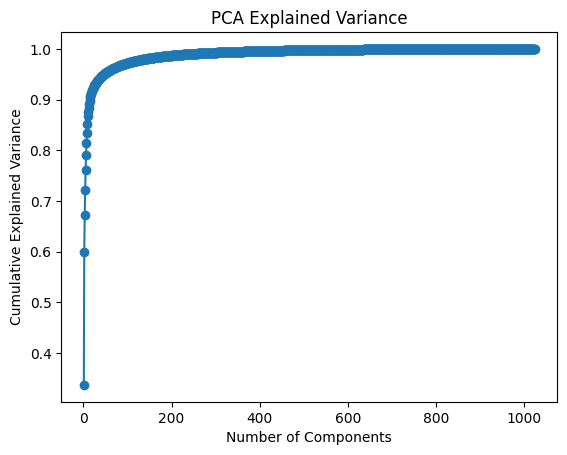

In [19]:
# use PCA (principle component analysis) to understand data variance and decide on the number of components to use for ICA
pca = PCA(n_components=None)  # All components
pca.fit(embedded_human_cells)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [20]:
# Decide n_components based on desired explained variance (e.g., 95%)
n_components_pca = np.argmax(cumulative_variance >= 0.95) + 1  # e.g., 95% of variance
print(f"Number of components to explain 95% variance: {n_components_pca}")

Number of components to explain 95% variance: 47


In [21]:
# use number of pca components to initialize Fast ICA object 
n_components = n_components_pca  

# create FastICA (independent component analysis) object with increased max_iter (default = 200) and tolerance (default = 0.0001)
ica = FastICA(n_components=n_components, max_iter=500, tol=0.001) 
# fit and transform human and mouse embeddings
human_ica = ica.fit_transform(embedded_human_cells)
mouse_ica = ica.fit_transform(embedded_mouse_cells) 

print("Human ICA shape:", human_ica.shape)
print("Mouse ICA shape:", mouse_ica.shape)

Human ICA shape: (1937, 47)
Mouse ICA shape: (1886, 47)


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


In [36]:
# create AnnData objects from the ICA-transformed embeddings
human_adata = anndata.AnnData(human_ica, obs=human_restricted.obs)
mouse_adata = anndata.AnnData(mouse_ica, obs=mouse_restricted.obs)

# Add species labels
human_adata.obs['species'] = 'human'
mouse_adata.obs['species'] = 'mouse'

human_adata.obs['cell_type'] = [x.lower() for x in human_adata.obs['cell_type']]
mouse_adata.obs['cell_type'] = [x.lower() for x in mouse_adata.obs['cell_type']]

# Before running CINEMA-OT, process the data to handle potential issues
def preprocess_for_ot(adata):
    nonzero_rows = np.sum(adata.X != 0, axis=1) > 0
    nonzero_cols = np.sum(adata.X != 0, axis=0) > 0
    adata = adata[nonzero_rows, :][:, nonzero_cols]
    return adata

# Preprocess combined_adata to ensure valid transport matrix
human_adata = preprocess_for_ot(human_adata)
mouse_adata = preprocess_for_ot(mouse_adata)

# Run PCA on data and store the result in obsm
sc.pp.pca(human_adata)
print(f"PCA shape: {human_adata.obsm['X_pca'].shape}")

sc.pp.pca(mouse_adata)
print(f"PCA shape: {mouse_adata.obsm['X_pca'].shape}")

PCA shape: (1937, 46)
PCA shape: (1886, 46)


In [37]:
mouse_adata

AnnData object with n_obs × n_vars = 1886 × 47
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [38]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')

# Run PCA on the combined AnnData
sc.pp.pca(combined_adata)

In [39]:
# Run CINEMA-OT
cf, ot_matrix, de = co.cinemaot.cinemaot_unweighted(
    combined_adata,
    obs_label='species',  # Column indicating species
    ref_label='human',    # Reference species
    expr_label='mouse',   # Experimental species
    mode='parametric',
    thres=0.5,
    smoothness=1e-3,
    eps=1e-3
)

In [40]:
# Display results
print("Confounder (cf) shape:", cf.shape)
print("Optimal Transport (ot) shape:", ot_matrix.shape)
print("Differential Expression (de) shape:", de.shape)

Confounder (cf) shape: (3823, 20)
Optimal Transport (ot) shape: (1937, 1886)
Differential Expression (de) shape: (1937, 47)


In [41]:
ot_matrix

array([[2.62687771e-07, 2.38394913e-07, 2.89143253e-07, ...,
        2.97887505e-07, 3.00040070e-07, 2.80119478e-07],
       [2.75040290e-07, 2.30478272e-07, 3.13788678e-07, ...,
        2.75563154e-07, 3.29746597e-07, 2.57793831e-07],
       [2.59239870e-07, 2.59345690e-07, 3.14742016e-07, ...,
        2.97391509e-07, 3.34479641e-07, 2.86302003e-07],
       ...,
       [3.02314349e-07, 2.97150112e-07, 2.49614873e-07, ...,
        2.36874691e-07, 3.01800275e-07, 2.66285803e-07],
       [2.94803946e-07, 2.49427078e-07, 2.77531173e-07, ...,
        2.34757565e-07, 3.08034629e-07, 2.17327130e-07],
       [2.58642452e-07, 2.95901675e-07, 2.55983502e-07, ...,
        2.89335094e-07, 2.60580503e-07, 3.31862864e-07]])

In [42]:
# Extract paired indices based on the optimal transport plan
paired_indices = []
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        paired_indices.append((human_idx, mouse_idx))

In [43]:
if not np.isnan(ot_matrix).any():
    # Extract paired indices based on the optimal transport plan
    paired_indices = []
    for human_idx in range(ot_matrix.shape[0]):
        if np.sum(ot_matrix[human_idx]) > 0:
            mouse_idx = np.argmax(ot_matrix[human_idx])
            paired_indices.append((human_idx, mouse_idx))

    # Print paired indices
    print("Optimal Transport Pairs (human_idx, mouse_idx):")
    for human_idx, mouse_idx in paired_indices:
        print(f"Human cell {human_idx} paired with Mouse cell {mouse_idx}")


Optimal Transport Pairs (human_idx, mouse_idx):
Human cell 0 paired with Mouse cell 278
Human cell 1 paired with Mouse cell 278
Human cell 2 paired with Mouse cell 278
Human cell 3 paired with Mouse cell 1849
Human cell 4 paired with Mouse cell 1481
Human cell 5 paired with Mouse cell 278
Human cell 6 paired with Mouse cell 172
Human cell 7 paired with Mouse cell 278
Human cell 8 paired with Mouse cell 787
Human cell 9 paired with Mouse cell 299
Human cell 10 paired with Mouse cell 106
Human cell 11 paired with Mouse cell 1439
Human cell 12 paired with Mouse cell 595
Human cell 13 paired with Mouse cell 99
Human cell 14 paired with Mouse cell 132
Human cell 15 paired with Mouse cell 1493
Human cell 16 paired with Mouse cell 1443
Human cell 17 paired with Mouse cell 545
Human cell 18 paired with Mouse cell 1249
Human cell 19 paired with Mouse cell 436
Human cell 20 paired with Mouse cell 1412
Human cell 21 paired with Mouse cell 1524
Human cell 22 paired with Mouse cell 434
Human cell 2

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


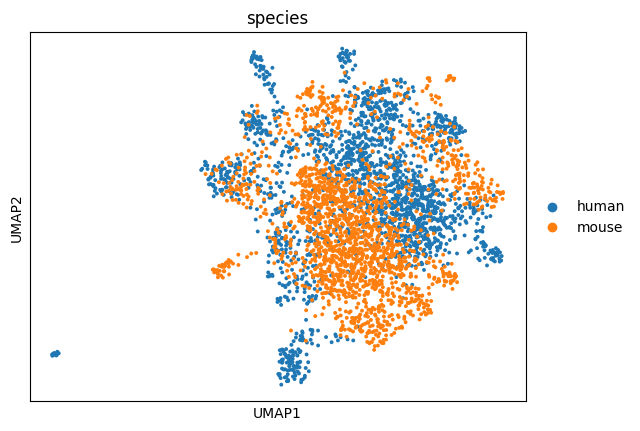

In [44]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)
combined_adata.obsm['cf'] = cf

# Visualize UMAP
sc.pl.umap(combined_adata, color=['species'])

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


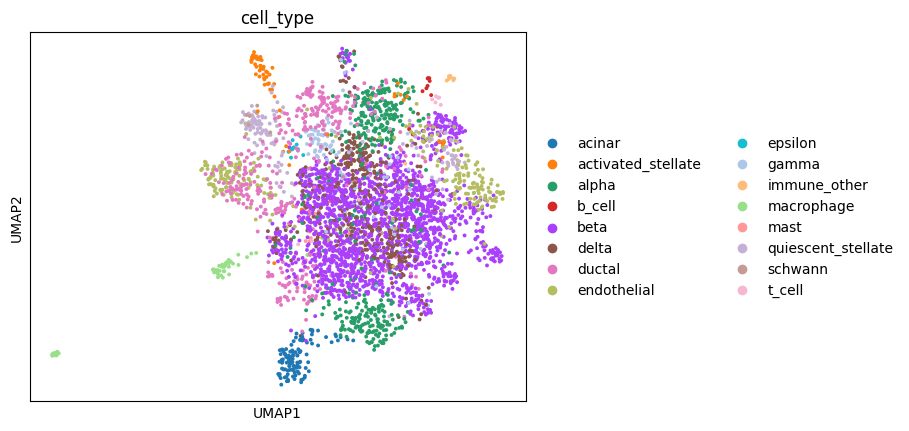

In [45]:

# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)
combined_adata.obsm['cf'] = cf

# Visualize UMAP
sc.pl.umap(combined_adata, color=['cell_type'])

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


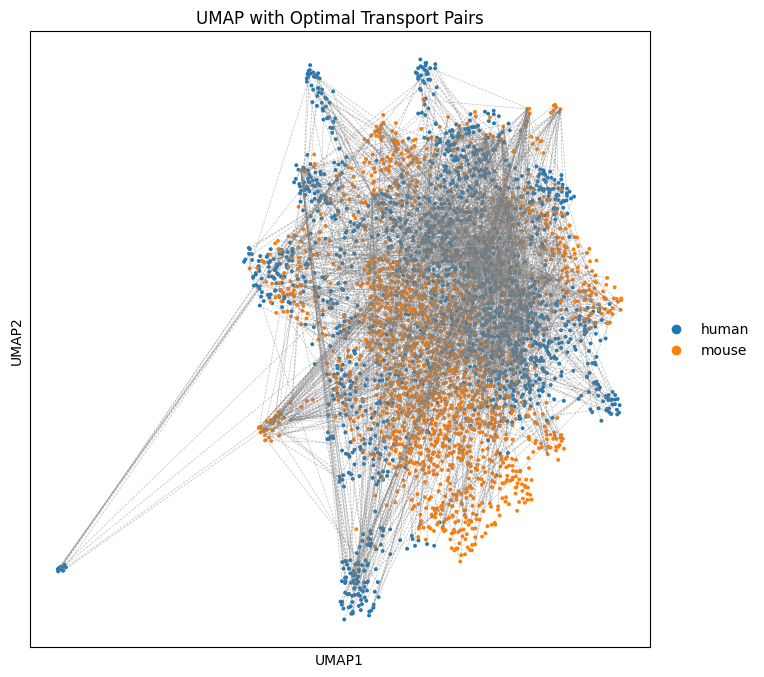

In [50]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['species'], ax=ax, show=False)
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


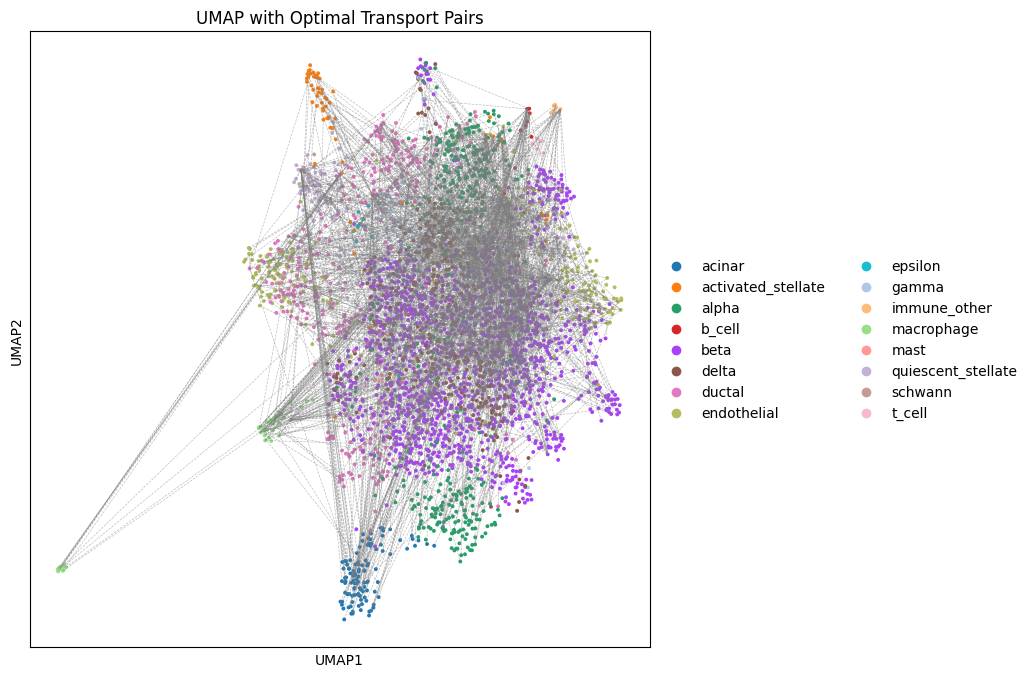

In [51]:
# Optional: Plot optimal transport pairs
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(combined_adata, color=['cell_type'], ax=ax, show=False)
for human_idx in range(ot_matrix.shape[0]):
    if np.sum(ot_matrix[human_idx]) > 0:
        mouse_idx = np.argmax(ot_matrix[human_idx])
        h = combined_adata.obsm['X_umap'][human_idx, :]
        m = combined_adata.obsm['X_umap'][mouse_idx + human_adata.shape[0], :]
        plt.plot([h[0], m[0]], [h[1], m[1]], color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title('UMAP with Optimal Transport Pairs')
plt.show()

In [52]:
# Extract true labels
human_labels = [x.lower() for x in human_adata.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_adata.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Find all unique labels present in either human or mouse labels
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)
print("All unique labels:", all_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']
All unique labels: ['acinar' 'activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'immune_other' 'macrophage' 'mast'
 'quiescent_stellate' 'schwann' 't_cell']


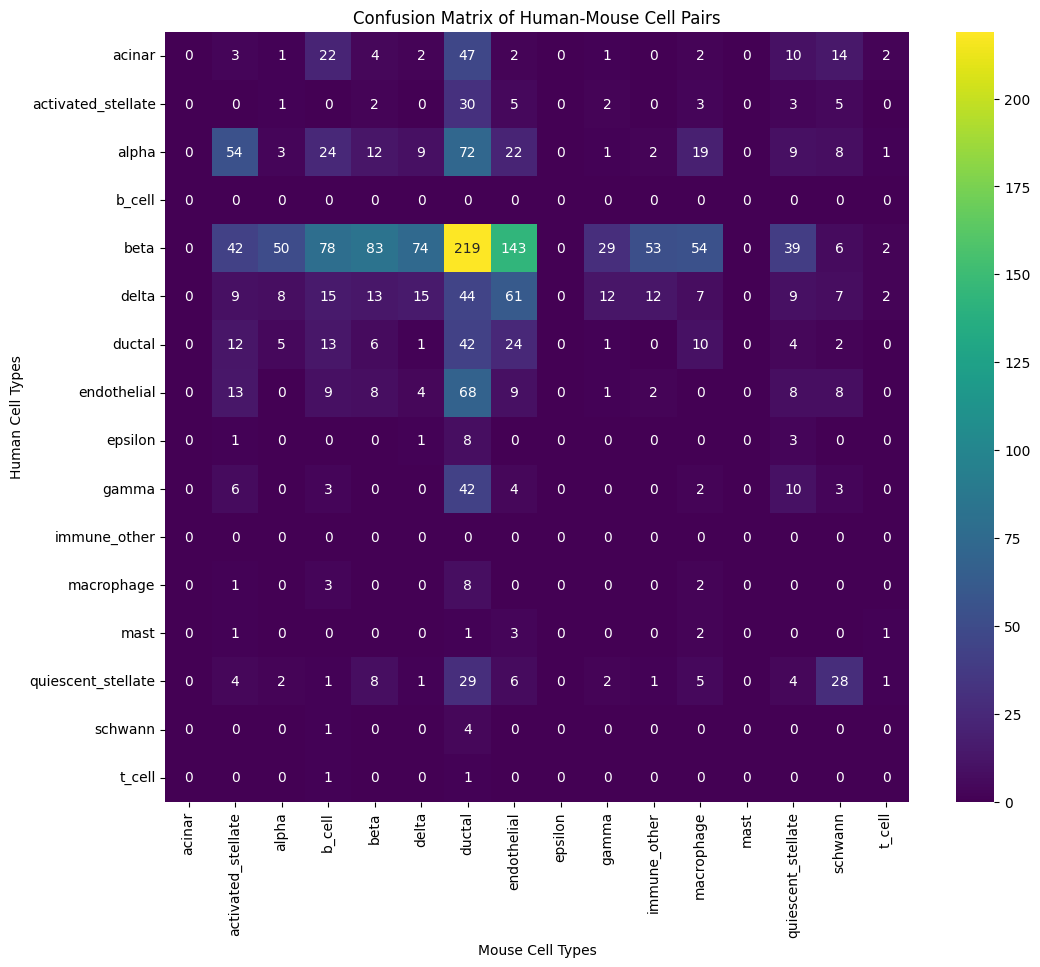

In [53]:
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Human-Mouse Cell Pairs')
plt.xlabel('Mouse Cell Types')
plt.ylabel('Human Cell Types')
plt.show()

In [59]:
all_cell_types = [
    'acinar', 'activated_stellate', 'alpha', 'b_cell', 'beta', 'delta', 'ductal', 
    'endothelial', 'epsilon', 'gamma', 'immune_other', 'macrophage', 'mast', 
    'quiescent_stellate', 'schwann', 't_cell'
]

# Initialize similarity matrix with zeros
similarity_matrix = pd.DataFrame(
    np.zeros((len(all_cell_types), len(all_cell_types))),
    index=all_cell_types,
    columns=all_cell_types
)

# Assign known similarities
similarity_matrix.loc['beta', 'delta'] = 0.7
similarity_matrix.loc['delta', 'beta'] = 0.7
similarity_matrix.loc['alpha', 'beta'] = 0.6
similarity_matrix.loc['beta', 'alpha'] = 0.6
similarity_matrix.loc['ductal', 'endothelial'] = 0.5
similarity_matrix.loc['endothelial', 'ductal'] = 0.5

# Alpha and delta cells are from the same tissue context
similarity_matrix.loc['alpha', 'delta'] = 0.5
similarity_matrix.loc['delta', 'alpha'] = 0.5

# Acinar and ductal cells are from the same tissue context (exocrine pancreas)
similarity_matrix.loc['acinar', 'ductal'] = 0.4
similarity_matrix.loc['ductal', 'acinar'] = 0.4

# Endothelial cells should have some general similarity across different cell types in circulatory system
similarity_matrix.loc['endothelial', 'macrophage'] = 0.3
similarity_matrix.loc['macrophage', 'endothelial'] = 0.3

# Quiescent and activated stellate similarity
similarity_matrix.loc['quiescent_stellate', 'activated_stellate'] = 0.6
similarity_matrix.loc['activated_stellate', 'quiescent_stellate'] = 0.6

# Activated stellate and macrophages showing some tissue remodeling and inflammation contexts
similarity_matrix.loc['activated_stellate', 'macrophage'] = 0.4
similarity_matrix.loc['macrophage', 'activated_stellate'] = 0.4

# The rest are zeros indicating no assumed similarity
print(similarity_matrix)

                    acinar  activated_stellate  alpha  b_cell  beta  delta  \
acinar                 0.0                 0.0    0.0     0.0   0.0    0.0   
activated_stellate     0.0                 0.0    0.0     0.0   0.0    0.0   
alpha                  0.0                 0.0    0.0     0.0   0.6    0.5   
b_cell                 0.0                 0.0    0.0     0.0   0.0    0.0   
beta                   0.0                 0.0    0.6     0.0   0.0    0.7   
delta                  0.0                 0.0    0.5     0.0   0.7    0.0   
ductal                 0.4                 0.0    0.0     0.0   0.0    0.0   
endothelial            0.0                 0.0    0.0     0.0   0.0    0.0   
epsilon                0.0                 0.0    0.0     0.0   0.0    0.0   
gamma                  0.0                 0.0    0.0     0.0   0.0    0.0   
immune_other           0.0                 0.0    0.0     0.0   0.0    0.0   
macrophage             0.0                 0.4    0.0     0.0   

In [62]:

# Generate scores based on confusion matrix and similarity matrix 

# Calculate weighted score
weighted_score = 0
for human_cell in all_cell_types:
    for mouse_cell in all_cell_types:
        count = cm_df.loc[human_cell, mouse_cell]
        sim_score = similarity_matrix.loc[human_cell, mouse_cell]
        weighted_score += count * sim_score

# Normalize by the maximum possible score
max_possible_score = cm_df.sum().sum()  # Total number of pairings
normalized_score = weighted_score / max_possible_score

# Print scores
print(f"Weighted Score: {weighted_score:.2f}")
print(f"Normalized Score: {normalized_score:.4f}")

Weighted Score: 177.20
Normalized Score: 0.0915
